## Preliminaries:

 Make sure you have numpy, scipy and matplotlib in python installation  
 * Use pip list in command line in terminal notebook was started from

In [1]:

import segyio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib  import gridspec
import matplotlib.cm as cm
import matplotlib.ticker as mtick
import scipy.signal as sig
import scipy.fft
from scipy.signal import butter,lfilter, freqs, freqz
from scipy.signal import sosfilt, sosfiltfilt, sosfreqz
from scipy.signal import minimum_phase, welch, medfilt
from scipy.signal import hilbert
from scipy.linalg import solve_toeplitz
from numpy.fft import fft, ifft, ifftshift
# make sure you have iovsp subdirectory
# the subdirectory should segyin.py and segyout.py
from iovsp import segyin 
from iovsp import segyout
# make sure you have plotvsp subdirectory
# the subdirectory should seisplots.py
from plotvsp import seisplots 

In [2]:
def depthlimit(VSPdata, headerfile, first, last):
    
    first = first - 1  #python indexing starts at 0, 
    last = last -1

    datanew = VSPdata[first:last,]    
    headernew = headerfile[first:last,]
    
    print("\u0332".join('\nDepthlimit Stats :'))    
    print(' data shape : ', VSPdata.shape, ' data dtype : ', VSPdata.dtype)    
    print (' headers shape :', headerfile.shape)    
    print (' first :', first, ' last : ', last )    
    print (' headers new shape :', headernew.shape)        
    print(' data new shape : ', datanew.shape)
    
    return datanew, headernew


## Slice arrays to get a single receiver 

In [3]:
def chosetrace(VSP, thead, num):

    num = num-1 # compensate for python zero-based indexing
    theadnew = thead[num:num+1,]
    datanew = VSP[num:num+1,]
    
    return datanew, theadnew


In [4]:
def geovel(thead, repvel, PTS):
    
    # calculate source-receiver offset
    # verticalize the times relative to source elevation
    # add in source to SRD time delay
    
    from tabulate import tabulate
    
    RcvX = thead[:,3]
    RcvY = thead[:,4]
    SrcX = thead[:,5]
    SrcY = thead[:,6]
    TVD_SRD = thead[:,9]
    TVD_Src = thead[:,10]
    SrcZ_SRD = thead[:,11]
    
    ttime = thead[:,8]
    
    a = RcvX - SrcX
    b = RcvY - SrcY
    
    SROffset = np.sqrt(a**2+b**2)

    VertTT_Src = ttime * np.cos(np.arctan(SROffset/TVD_Src))
    VertTT_SRD = VertTT_Src - ((SrcZ_SRD)/repvel)
    
#    print (time,VertTT_SRD)

    T_Diff = np.ediff1d(VertTT_SRD/1000)
    D_Diff = np.ediff1d(TVD_SRD)
    firstTDiff = VertTT_SRD[0]/1000
    firstDDiff = TVD_SRD[0]
    TDiff = np.hstack((firstTDiff, T_Diff))
    DDiff = np.hstack((firstDDiff, D_Diff))

    IntVel = DDiff/TDiff

    FirstVel = TVD_SRD[0]/VertTT_SRD[0]
    DisplayVelRnd = np.rint(IntVel)             #round and convert to integer
    DisplayVelInt=DisplayVelRnd.astype(int)
    
    IntVel = IntVel.reshape(-1,1)
    
    vheaders = np.hstack((thead, IntVel))
    
    if (PTS == 'y') or (PTS == 'Y'):
    
        pdat = np.vstack((TVD_SRD, VertTT_SRD,TDiff, DDiff, IntVel)).T
    
        headers = ["Depth SRD", "Vert Time SRD", "Delta T", "Delta Z","Vp"]
    
        table = tabulate(pdat, headers, tablefmt="fancy_grid")

        print(table) 
        
    print("\u0332".join('\nGeoVel Stats :'))    
    print (' headers shape :', thead.shape)    
    print (' intvel shape :', IntVel.shape, ' firstvel : ', FirstVel )    
    print (' vheaders shape :', vheaders.shape)    
    print (' TVDSrc 2 vals  ',TVD_Src[0:2],'\n TVDSRD 2 vals ',TVD_SRD[0:2],
           '\n TTVert 2 vals  ', VertTT_SRD[0:2])
    
    return vheaders 


## Trace normalize data file

Normalize by row (receiver) using Frobenius normalization. Can be changed to other norms.  
* Be careful with axis number, determines trace normalization or time normalization.

stackoverflow.com/questions/8904694/how-to-normalize-a-2-dimensional-numpy-array-in-python-less-verbose

In [5]:
def normalize (Seismic, norm, thead, scal):
    """
    data normalization
    Frobenius norm is the default, L1 norm optional using data.sum
    row_sums = data.sum(axis=1)

    This method takes the whole trace, zeros before TT included so result 
    can be unexpected
    
    I need to create a method for normalizing in a window then apply 
    that norm factor to the whole trace
    """
    
    print("\u0332".join('\nNormalization Stats :'))
    print(' Seismic type : ', Seismic.dtype)    
    
    rdepth = thead[:,2]
    
    data2 = np.zeros(shape = (Seismic.shape[0], Seismic.shape[1]), dtype=np.float32)    
    data1 = Seismic
    
    if (norm == 'Y') or (norm =='y'):        
        row_sums = np.linalg.norm(data1, axis=1)        
        print (' row_sums shape', row_sums.shape)        
        data2 = (data1 / row_sums[:, np.newaxis])        
        datascaled = data2 * scal
        
    else:        
        datascaled = data1 * scal
        
    plt.figure(figsize=(10,5))    
    ax1 = plt.subplot(111)
    ax1.plot(rdepth, row_sums, c = 'red')  # using fftfreq to get x axis    
    ax1.set_title('Norm Factors') # %s at Depth %s'
                 # %(title_spec, zrcv_select))    
    ax1.set_xlabel('TVD Depth')    
    ax1.xaxis.grid()    
    ax1.yaxis.grid()
    plt.show()
      
    return datascaled


## Apply Butterworth Filter

Meake 2 simple QC plots of frequency and impulse response

In [6]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order, N, QCP):
    '''
    for description of using Second Order Section (sos) instead of b,a
    see https://stackoverflow.com/questions/12093594/
    how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
    recently updated
    '''
    # frequencies are normalized by nyquist frequency
    nyq = 0.5 * fs
    low = lowcut / nyq    
    high = highcut / nyq        
    sos_out = butter(order, [low, high], analog=False, btype='band', output='sos')

    # create a time axis symmetric around zero
    dt = 1/fs
    t = np.arange(-N*dt/2,N*dt/2,dt)

    buttfilt = sosfiltfilt(sos_out, data)
    buttfilt = np.float32(buttfilt)#temporary fix to type getting changed bug
    ordertest = order
    
    if (QCP == 'y') or (QCP =='Y'):
        # get a discrete time impulse response 
        center = N//2  #seems important to keep spike at middle of window    
        x = np.zeros(N, dtype=np.float32)     
        x[center] = 1     
        coeff = sosfiltfilt(sos_out, x)    
#        coeffmin = minimum_phase(coeff, method='hilbert')
        
        fig = plt.figure(figsize=(15,5))    
        gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], wspace = .15)
    
        ax1 = plt.subplot(gs[0])    
        for ordertest in [ordertest, ordertest*2, ordertest *3]:        
            sostest = butter(ordertest, [low, high], analog=False, btype='band', output='sos')        
            w, h = sosfreqz(sostest, worN=512)        
            ax1.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % ordertest)

        ax1.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')        
        ax1.set_xlim(0, highcut*4)       # half of nyquist should be good enough    
        ax1.set_xlabel('Frequency (Hz)')    
        ax1.set_ylabel('Gain')    
        ax1.grid(True)    
        ax1.legend(loc='best')        
        ax1.set_title('Butterworth Filter %sHz low cut, %sHz high cut, order =%s'
                      %(lowcut, highcut, order),fontsize=14)
    
        ax2 = plt.subplot(gs[1])    
        ax2.plot(t,coeff, c='red', label = ' %s Order Zero-phase Butterworth'
                 %(order) )                                              
        ax2.set_title('Butterworth Impulse Response %sHz lowcut, %sHz highcut, order=%s'
                      %(lowcut, highcut, order),fontsize=14)    
        ax2.set_xlabel('Time (s)')        
        ax2.legend(loc='lower left',borderaxespad=0, fontsize = 10)        
        ax2.grid(True)        
        plt.show()

    return buttfilt

In [7]:
def simple_bpf(VSPdata, f1, f2, transL,transH, fs ):
    
    '''from excellent tutorial at:
    https://tomroelandts.com/articles/how-to-create-simple-band-pass-and-band-reject-filters
    
    Convolve the data trace with a sinc function. Numpy has an easy sinc generator
    
    - transL is the transition band or the low pass filter - the high frequency roll-off
    - transH is the transition band or the high pass filter - the low frequency roll-off
    '''

    print("\u0332".join('\nSimple BPF Information :'))
#    plt.rcParams.update({'font.size': 12})
    
    L=1024 # length of frequency response
    samprate = 1/fs            #sample rate in seconds
    
    dt = 1/fs
 
    fL = f1/fs  # Cutoff frequency as a fraction of the sampling rate 
    fH = f2/fs  # Cutoff frequency as a fraction of the sampling rate 
    bL = transH/fs  # Transition band, as a fraction of the sampling rate 
    bH = transL/fs  # Transition band, as a fraction of the sampling rate 
    NL = int(np.ceil((4 / bL))) # samples in low pass
    NH = int(np.ceil((4 / bH))) # samples in high pass

    if not NL % 2: NL += 1  # Make sure that NL is odd.
    nL = np.arange(NL)
    if not NH % 2: NH += 1  # Make sure that NH is odd.
    nH = np.arange(NH)
 
    # Compute a low-pass filter with cutoff frequency fH.
    hlpf = np.sinc(2 * fH * (nL - (NL - 1) / 2))
    hlpf *= np.blackman(NL)
    hlpf = hlpf / np.sum(hlpf)
 
    # Compute a high-pass filter with cutoff frequency fL.
    hhpf = np.sinc(2 * fL * (nH - (NH - 1) / 2))
    hhpf *= np.blackman(NH)
    hhpf = hhpf / np.sum(hhpf)
    hhpf = -hhpf
    hhpf[(NH - 1) // 2] += 1
    
    # Convolve both filters.    
    h = np.convolve(hlpf, hhpf)

    # Pad filter with zeros.
    h_padded = np.zeros(L)
    h_padded[0:h.shape[0]] = h
    
    # do the fft
    H = np.abs(np.fft.fft(h_padded))
    freq = np.fft.fftfreq(H.shape[0], d=dt)    # Generate plot frequency axis
    #########
    keep = freq>=0    
    H = H[keep]    
    freq = freq[keep]    
 
    # apply filter to data
    BPFdata = np.zeros(shape = (VSPdata.shape[0], VSPdata.shape[1]), dtype=np.float32)          
    for k in range(0,(VSPdata.shape[0])):        
        BPFdata[k,:-1] = np.convolve(VSPdata[k,:-1],h, mode='same')

    # Plot frequency response (in amplitude and dB) and impulse response                        
    fig = plt.figure(figsize=(15,5))    
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1], wspace = .25)
    
    ax1 = plt.subplot(gs[0])    
    ax1.plot(freq,H)      
    ax1.set_xlim(0, f2*2)       # subjective choice
    ax1.set_xlabel('Frequency (Hz)')    
    ax1.set_ylabel('Gain')    
    ax1.grid(True)    
#    ax1.legend(loc='best',borderaxespad=0, fontsize = 8)        
    ax1.set_title('Simple Bandpass Frequency Response\n%s hz to %s hz passband \n%s hz low taper , %s hz high taper'%(f1, f2, transH, transL),fontsize=12)

    ax2 = plt.subplot(gs[1])    
    ax2.plot(freq, 20 * np.log10(H))      
    ax2.set_xlim(0, f2*4)      # subjective choice
    ax2.set_ylim(-200,0)       # subjective choice
    ax2.set_xlabel('Frequency (Hz)')    
    ax2.set_ylabel('Gain [dB]')    
    ax2.grid(True)    
#    ax2.legend(loc='best',borderaxespad=0, fontsize = 8)        
    ax2.set_title('Simple Bandpass Frequency Response\n%s hz to %s hz passband \n%s hz low taper , %s hz high taper'%(f1, f2, transH, transL),fontsize=12)    
    
    ax3 = plt.subplot(gs[2])    
    x = np.arange((-h.shape[0]*dt)/2, (h.shape[0]*dt)/2, dt)
    ax3.plot(x,h, c='red')                                              
    ax3.set_title('Simple Bandpass Impulse Response\n%s hz to %s hz passband \n%s hz low taper , %s hz high taper'%(f1, f2, transH, transL),fontsize=12)    
    ax3.set_xlabel('Time (s)')        
#    ax3.legend(loc='upper right',borderaxespad=0, fontsize = 8)        
    ax3.grid(True)        
    plt.show()

    return BPFdata


In [8]:
def ormsby(duration, dt, f):
    """
    https://github.com/agile-geoscience/bruges/blob/master/bruges/filters/wavelets.py
    
    The Ormsby wavelet requires four frequencies which together define a
    trapezoid shape in the spectrum. The Ormsby wavelet has several sidelobes,
    unlike Ricker wavelets.
    Args:
        duration (float): The length in seconds of the wavelet.
        dt (float): The sample interval in seconds (usually 0.001, 0.002,
            or 0.004).
        f (ndarray): Sequence of form (f1, f2, f3, f4), or list of lists of
            frequencies, which will return a 2D wavelet bank.
    Returns:
        ndarray: A vector containing the Ormsby wavelet, or a bank of them.
    """
    f = np.asanyarray(f).reshape(-1, 1)

    try:
        f1, f2, f3, f4 = f
    except ValueError:
        raise ValueError("The last dimension must be 4")

    def numerator(f, t):
        return (np.sinc(f * t)**2) * ((np.pi * f) ** 2)

    pf43 = (np.pi * f4) - (np.pi * f3)
    pf21 = (np.pi * f2) - (np.pi * f1)

    t = np.arange(-duration/2, duration/2, dt)

    w = ((numerator(f4, t)/pf43) - (numerator(f3, t)/pf43) -
         (numerator(f2, t)/pf21) + (numerator(f1, t)/pf21))
    
    print (' presqueeze w shape :', w.shape)

    w = np.squeeze(w) / np.amax(w)
    
    # make filter plots
    
    plt.figure(figsize=(15, 5))    

    ax1 = plt.subplot(111)    
    ax1.plot(t, w, c = 'red')  # using fftfreq to get x axis    
    ax1.set_title('Ormsby wave low cut %s low pass %s high pass %s high cut %s'
                  %(f[0], f[1],f[2],f[3]))    
    ax1.set_xlabel('Time')
    ax1.xaxis.grid()    
    ax1.yaxis.grid()

    plt.show() 

    return w


In [9]:
def ricker(duration, dt, f):
    """
    https://github.com/agile-geoscience/bruges/blob/master/bruges/filters/wavelets.py
    
    Also known as the mexican hat wavelet, models the function:
    
    .. math::
        A =  (1 - 2 \pi^2 f^2 t^2) e^{-\pi^2 f^2 t^2}
    If you pass a 1D array of frequencies, you get a wavelet bank in return.
    Args:
        duration (float): The length in seconds of the wavelet.
        dt (float): The sample interval in seconds (often one of  0.001, 0.002,
            or 0.004).
        f (ndarray): Centre frequency of the wavelet in Hz. If a sequence is
            passed, you will get a 2D array in return, one row per frequency.

    Returns:
        ndarray. Ricker wavelet(s) with centre frequency f sampled on t.
    .. plot::
        plt.plot(bruges.filters.ricker(.5, 0.002, 40))
     
    """
    f = np.asanyarray(f).reshape(-1, 1)
    t = np.arange(-duration/2, duration/2, dt)
    pft2 = (np.pi * f * t)**2
    w = np.squeeze((1 - (2 * pft2)) * np.exp(-pft2))
    
    ############   make single trace plots   ################
    
    plt.figure(figsize=(15,5))
    
    ax1 = plt.subplot(111)    
    ax1.plot(t, w, c = 'red')  # using fftfreq to get x axis    
    ax1.set_title('Ricker wave %s Hertz'%(f))    
    ax1.set_xlabel('Time')    
#    ax1.set_xlim(0,200)    
    ax1.xaxis.grid()    
    ax1.yaxis.grid()

    plt.show() 

    return w

In [10]:
def butterworth(lowcut, highcut, fs, N, order):

    '''Generate a butterworth wavelet.
     For description of using Second Order Section (sos) instead of b,a
     see https://stackoverflow.com/questions/12093594/
     how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
    '''     
    print("\u0332".join('\nButterworth Wavelet Parameters :'))    
    print ('\n fs :',fs, ' N :',N,' order :',order)

    '''
    # The standard way 
    b, a = butter(order, [low, high], btype='band')    
    #get a discrete time impulse respnse    
    x = np.zeros(N)     
    x[center] = 1     
    coeff = filtfilt(b,a, x)
    '''
    dt = 1/fs
    t = np.arange((-N*dt)/2, (N*dt)/2, dt)
    nyq = 0.5 * fs        
    low = lowcut / nyq    
    high = highcut / nyq        
    sos_out = butter(order, [low, high], btype='band', output='sos')
    
    center = (N//2)+1  # if N odd, keeps spike at middle of window    
    x = np.zeros(N)     
    x[center] = 1    
    print (' center :', center,' a few values of x :','\n', x[center -5:center+5])    
    coeff = sosfiltfilt(sos_out, x)
        
    # make single trace plots    
    plt.figure(figsize=(15,5))
    
    ax1 = plt.subplot(111)    
    ax1.plot(t,coeff, c = 'red')  # using fftfreq to get x axis
    ax1.set_title('Butterworth Wave %sHz lowcut, %sHz highcut order= %s'
                  %(lowcut, highcut,order))    
    ax1.set_xlabel('Time')    
    ax1.xaxis.grid()   
    ax1.yaxis.grid()

    plt.show()
    
    return coeff

In [11]:
def nextpow2(x): 
    ''' find a number that is a power of 2
    from https://stackoverflow.com/questions/14267555/find-the-
    smallest-power-of-2-greater-than-n-in-python
    ''' 
    if x == 0:            
        y = 1
       
    else: y = np.ceil(np.log2(x))
        
    print("\u0332".join('\nnextpow2 info and parameters') )
    print(' x :', x)
    print(' nextpow2 :', y)    

    return int(y)

In [12]:
def fktran_numpy(seis,headers, fs, ishift, comment1, linevel):
    '''2D fft to generate fk plot
    seis - VSP data matrix
    headers - need receiver depths
    fs - sampling rate in hertz

    This assumes constant receeiver spacing!
    '''
    numsamp, ntrace = seis.T.shape            # data needs to be 1 trace/column    
    t = np.arange(0, numsamp*(1/fs),(1/fs) )  # convert fs in hertz to seconds    
    dt = t[1]-t[0]                            # could have used 1/fs b
    
    rcvz = headers[:,1] #rcvdepth               # needs constant rcv separation
    dx = rcvz[1] - rcvz[0]    
    nf = int(2 ** nextpow2(len(t)))
#    nk = int(2 ** nextpow2(len(x)))          # use for minimizing array size     
    nk  = nf                                  # use for better resolution in k 
    plotnf = int(nf/2+1)                      # plot only positive frequencies
    
    print("\u0332".join('\nfktran_numpy info and parameters before fft') )            
    print(' seis.T shape :',seis.T.shape,'\n numsamp :', numsamp, \
          '\n ntrace :', ntrace)       
    print(' rcvz shape :',rcvz.shape,'\n t shape :', t.shape, '\n dx :', \
          dx,'\n dt :', dt)    
    print(' nf :',nf,'\n nk :', nk)
    
    fk = np.fft.fftshift(np.fft.fft2(seis,s=(nk,nf))) # fftshift puts 0 freq and 
                                                      # 0 k in middle of output          
    freq = np.fft.fftfreq(fk.shape[1], dt)            # get the freq. bin values 
                                                      #from axis 1 of fk array
    freq_unwrap = np.fft.fftshift(freq)               # re-arrange so 0 freq is 
                                                      # the middle of the array
    
    k = np.fft.fftfreq(fk.shape[0], dx)    
    k_unwrap = np.fft.fftshift(k)
    print(' fk shape :',fk.shape)    
    print ( ' freq min', freq.min(),' freq max', freq.max())    
    print ( ' k min', k.min(),' k max', k.max())

    scalar = 1    
    DBmax = -60    
    fk_for_plot = fk    
    if ishift == 1:    
        fk_for_plot = fk_for_plot[:,plotnf:]        
        print (' fk_for_plot shape :',fk_for_plot.shape)
    
    fk_plot(fk_for_plot, freq_unwrap, k_unwrap, fs, rcvz, scalar, DBmax,\
            comment1,linevel)
    
    return fk, freq_unwrap, k_unwrap, numsamp,ntrace

In [13]:
def invfk_numpy(fk, numsamp, ntrace):    
    ''' inverse 2d fft to transform to depth-time
    '''        
    VSP_invtrans = np.fft.ifft2(np.fft.ifftshift(fk))
    
    print("\u0332".join('\ninv fk numpy info and parameters ') )    
    print (' fk shape :', fk.shape)
    print(' VSP_invtran shape :',VSP_invtrans.shape)    

    # get real component
    VSP_invtrans = np.real(VSP_invtrans[:ntrace,:numsamp])
    
    return VSP_invtrans

In [14]:
def fk_plot(FKdata, f, k, fs, rcvdepth,scal, dbmax,txt1,vel):

#    plt.rcParams.update({'font.size': 16}) # may affect other plots
    
    FKdata = FKdata.T                    # to get frequency on y axis    
    kmin, kmax, fmin, fmax = -.0075, .0075, 0, 80
#    kmin, kmax, fmin, fmax = k.min(),k.max(), f.min(), f.max()
    
    FKdata = np.absolute(FKdata)    # get magnitude of complex values of FKdata 
                                    # np. real could be tried to get real comp.
    FKdata = 20*np.log10((FKdata)/np.max(FKdata))  # Convert to db 20 * np.log10\
                                                   # (S / np.max(S))
    
    df =f[1] - f[0]                                # sample rate in hz    
    stopf = int(fmax/df)                           # get correct stop index    
    dk = k[1]-k[0]    
    startk = int(abs((k.min() - kmin)/dk))    
    stopk = startk + int(kmax/dk*2)

    print("\u0332".join('\nfk plot info and parameters') )    
    print ('fk shape :', FKdata.shape)       
    print(' df :',df,'\n stop freq index :', stopf, '\n f shape :', f.shape, \
          '\n dk :', dk, '\n startk :', startk, '\n stopk :',stopk)     
    
    FKdata =  FKdata[0:stopf,startk:stopk]

    # get velocity line end points
    kvel=[0,np.max(f)/vel]
    fvel=[0,np.max(f)]
    slope=np.max(f)/(np.max(f)/vel) # line always strts at 0,0
    print(' kvel, fvel:',kvel,fvel,' slope :', slope)    
    # locate velocity annotation
    xylabel = (kmax/2, (slope*(kmax/2)))
    if (slope < 0):
        xylabel = (-1*kmax/2, -1*(slope*(kmax/2)))

    label = 'Velocity = %s'%(vel)    
    print(' xy label location:',xylabel)

    # plot spectra in dB     
    fig = plt.figure(figsize=(12,10))    
    ax1 = fig.add_subplot(111)    

    plot1 = ax1.imshow(FKdata, cmap="gist_rainbow", interpolation='none', \
            vmin = dbmax,vmax = 0,extent = [kmin, kmax, fmax, fmin],\
            aspect = 'auto')
    ax1.set_xlim(kmin, kmax)
    ax1.set_ylim(fmax, fmin)
    ax1.plot(kvel,fvel,c='k',linewidth=4, linestyle='--', marker='')
    ax1.yaxis.grid()    
    ax1.set_xlabel('Wavenumber 1\\ft')
    ax1.set_ylabel('Frequency (hz)')    
    ax1.set_title('%s'%(txt1))
    # get rotation angle for velocity annotation
    p1 = ax1.transData.transform_point((kvel[0], fvel[0]))
    p2 = ax1.transData.transform_point((kvel[1], fvel[1]))
    dy = (p2[1] - p1[1])
    dx = (p2[0] - p1[0])
    rotn = np.degrees(np.arctan2(dy, dx))
    if (vel<0):
        rotn=rotn-180
    txtbox = ax1.annotate(label, xy=xylabel, ha='center', va='center', rotation=rotn)
    txtbox.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))
    # plot a colorbar    
    pad = 0.03    
    width = 0.02    
    pos = ax1.get_position()    
    axcol = fig.add_axes([pos.xmax + pad, pos.ymin, width, \
                          0.9*(pos.ymax-pos.ymin) ])
    fig.colorbar(plot1, label = 'Amplitude in db', cax = axcol, aspect = 40)
        
    plt.show()

## Static shift of traces

Shifts by a time header value  
Arbitrary time can be used to align data at

In [15]:
def shift(arr, tracehead, align, atime, fs):

    """ Shift VSP to align along direct arrival or to Two Way Time
   
    Adapted from from https://stackoverflow.com/questions/30399534/
                           shift-elements-in-a-numpy-array
    
    arr = VSP data array
    thead = header array to get xshift, the observed time header for indexing
    align = switch for alignment or shits to one-way or two-way time
    atime  = time to be aligned along 
    
    """
    
    print("\u0332".join('\nShifting Parameters :'))
    
    newhead = np.copy(tracehead)
    
    xshift = tracehead[:,8] * (fs/1000) # get index number for travel time    
    atime = int(atime *(fs/1000))       # get index number for alignment time
    
    arr2 = np.zeros(shape = (arr.shape[0], arr.shape[1]), dtype=np.float32)            
    print ('fs :', fs,'\n', 'atime :', atime,'\n','first arr2 shape :', 
           arr2.shape)           
    pad_align = atime      # shallow traces can be cut of if atime > xshift    
    pad_twt = arr.shape[1]-int(np.max(xshift))
                               
    if align == 'up':        
        xshift = xshift.astype(int)        
        arr = np.pad(arr, ((0,0),(0, pad_twt)), 'constant')
        print ('pad twt : ', pad_twt, 'arr shape :', arr.shape)        
        newhead[:,8] = tracehead[:,8] * 2        
        arr2 = np.zeros(shape = (arr.shape[0], arr.shape[1]),dtype=np.float32)        
        print ('second arr2 shape :', arr2.shape)
               
    elif align == 'down':        
        xshift = xshift - atime        
        xshift = xshift.astype(int) * -1        
        arr = np.pad(arr, ((0,0),(0, pad_align)), 'constant')        
        arr2 = np.zeros(shape = (arr.shape[0], arr.shape[1]),dtype=np.float32)
        
    elif align == 'unalign':        
        xshift = xshift.astype(int) - atime 

    for i, trace in enumerate(arr[::1, :]):        
        arr2[i,] = np.roll(arr[i,],xshift[i]) # carefulwith input array shape
        
        if xshift[i] > 0:            
            arr2[i,:xshift[i]] = 0            # [1, 4000] need row number 0            
        elif xshift[i] < 0:            
            arr2[i,xshift[i]:] = 0
            
    return arr2, newhead 


## Wiggle trace - single, sideways

Crossplot x (amplitude) and y (time). Add amplitude to receiver depth to get trace deflection. 

Alternatively add amplitude to receiver number to get trace deflection.



In [16]:
def plotsingletrace( VSP1, Tmin, Tmax, thead, spacing, scal1,fs, title):
    
    rcv_depth = thead[0:1,2]
    trace_num = thead[0:1,0]
    
    data1scaled = VSP1 * scal1
        
    print("\u0332".join('\nSingle Trace Plot Global Information :'))    
    print ('VSP1 shape :', VSP1.shape)
    print ('VSP1 type :', VSP1.dtype)
    print ('data1scaled shape :', data1scaled.shape)
    
    y = np.arange(0, data1scaled.shape[0],1/fs )
 
    if (spacing == 'Z') or (spacing == 'z'):        
        dscaler, pad = (rcv_depth, rcv_depth/10)        
        dlabel = 'Receiver Depth'
        
    else:    
        dscaler, pad = (trace_num, 2)        
        dlabel = 'Receiver Number'

    x = data1scaled + dscaler    
    xflat = x.ravel()
    
    print ('data1scaled shape [0] :', data1scaled.shape[0], 
           ' Number of samples per trace [1] :', data1scaled.shape[1])    
    print (' x shape :', x.shape, ' x flat shape :', xflat.shape)
            
    fig = plt.figure(figsize=(15,10))    
    gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], wspace = .25)
    
    ax1 = plt.subplot(gs[0])    
    ax1.plot(y, xflat, 'k-', linewidth = .5)
    ax1.fill_between(y, dscaler, xflat, where=(xflat> dscaler), color='k')    
#    ax1.set_ylim(dscaler-pad, dscaler+pad )
    ax1.set_xlim(Tmin, Tmax)
    ax1.set_yticks(dscaler[-1:1:]) #careful with the first and last    
    ax1.set_ylabel(dlabel)    
    ax1.set_title('%s'%(title), fontsize = 14)   
    for label in ax1.yaxis.get_ticklabels():  
        label.set_rotation(90)        
    ax1.xaxis.grid()
    
    plt.show()


# Frequency Analysis

Plot input trace, plot windowed trace. Leading zeros needed to avoid tapering direct arrival

Do FFT of whole trace - including leading zeros

In [17]:
def FrAn(data, timerange, frange, thead, trace, fs,twin, title_spec):    
    ''' Frequency Analysis of whole trace
        Uses scipy fft and avoids using powers of 2 for number of taps
        
        timerange - desired analysis window 
        twin - apply analyis window 'y' or use whole trace 'n'
        trace - trace number to extract from 2D data array
        fs - sample rate in hertz
        scale - scales amplitude of trace plot, >1 makes plot hotter

    '''
    import math 
    from math import ceil
        
    dt =1/fs *1000             # sample rate in ms
    samprate = 1/fs            #sample rate in seconds
    
    print("\u0332".join('\nFrAn Parameters :'))    
    print ('fs :', fs,)

    # extract analysis trace
    data_single, thead_single = chosetrace(data, thead, trace)    
    data_single = data_single.T # samples in a column

    # useful headers
    TTobs_single = thead_single[:,8]
    zrcv_select = thead_single[:,2]
    trnum_single = thead_single[:,0]

    ####### optimize number of samples for transform  #############

    # for a segment of trace
    if (twin =='y')or(twin=='Y'):
        start = int(timerange[0]*(fs/1000))
        stop = int(start+(timerange[1]*(fs/1000)))
        data_trimd = data_single[start:stop,]
        
        # Apply window to segment
        w=sig.tukey(data_trimd.shape[0], alpha=.1)    
        data_win = data_trimd[:,0]*w        # Multiply trace by window
        N = scipy.fft.next_fast_len(int(timerange[1]-timerange[0]*(fs/1000)))
    
    # for a full trace
    else:
        # Apply window to whole trace
        w=sig.tukey(data_single.shape[0], alpha=.1)    
        data_win = data_single[:,0]*w        # Multiply trace by window    
        N = scipy.fft.next_fast_len(data_win.shape[0]) # in samples, best for scipy fft
    
    # pad with zeros if optimal N greater than trace or segment
    if (N > data_win.shape[0]):                    
        pad = N - data_win.shape[0]
        data_win = np.pad(data_win, (0,int(pad)), 'constant')

    ####### do the fft  #############
    
    X = scipy.fft.fft(data_win[:])      # from 0, to TT plus window 
                                                 # [:] if a window is used    
    X_db = 20*np.log10(np.abs(X)/np.max(np.abs(X)))# db=20*np.log10(S/np.max(S))
    
    freq = scipy.fft.fftfreq(X.shape[0], d=samprate)    # Generate plot frequency axis     
#    f = np.arange(0, N)*fs/N                # alternate method
                                                           
    ####### Only keep positive frequencies #########
    
    keep = freq>=0    
    X = X[keep]    
    X_db = X_db[keep]    
    freq = freq[keep]

    ############   make Spectral plots   ################
    
    plt.figure(figsize=(15,5))    
    ax1 = plt.subplot(121)    

    ax1.plot(freq, np.absolute(X), c = 'red')  # using fftfreq to get x axis    

    ax1.set_title('Amplitude Spectrum of %s at Depth %s'
                  %(title_spec, zrcv_select))    
    ax1.set_xlabel('Frequency hz')    
    ax1.set_xlim(frange[0], frange[1]) # extents must be set   
    ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    ax1.set_ylabel('Amplitude')    
    ax1.xaxis.grid()    
    ax1.yaxis.grid()

    ax2 = plt.subplot(122)
    
    ax2.plot(freq,X_db, c='blue') #using number of samples and sample rate to get x axis
    
    ax2.set_title('Power Spectrum in db of %s at Depth %s'
                  %(title_spec, zrcv_select))    
    ax2.set_xlabel('Frequency hz')
    ax2.set_xlim(frange[0], frange[1]) # extents must be set   
    ax2.set_ylabel('Power(db)')    
    ax2.xaxis.grid()    
    ax2.yaxis.grid()

    plt.show() 

In [18]:
def FrAn_2d(idata, timerange, thead, fs,spacing, dbrange,frange, trrange,scale, title_spec, twin):
    ''' Frequency Analysis of every trace    
        Uses scipy fft 
        Number of taps defined using next_fast_len, not next pow 2
        
        timerange - only the end time is used
        frange - plot frequency range
        dbrange - plot db range
        trace - trace number to extract from 2D data array
        fs - sample rate in hertz
        scale - scalar applied to amplitude of spectral plot
    '''

    import math 
    from math import ceil
    
    window = 'y' # put as arg

    TTobs = thead[:,8]
    rcvdepth = thead[:,2]
    trnum = thead[:,0]
    sdb=dbrange[1]
    edb=dbrange[0]
    
    idata=idata[trrange[0]:trrange[1],:]
    
    trindex  = np.stack([trnum for _ in range(idata.shape[0])], axis=1)
    
    print("\u0332".join('\nFrAn image2 Parameters :'))    
    print (' data shape :',idata.shape, ' TTobs shape :',
           TTobs.shape)
    print (' trindex.min():',trindex.min(), ' trindex.max():',trindex.max())
    print ('fs :', fs,)

    ####### window the trace to prevent edge effect in fft  #############
    
    dt =1/fs *1000             # sample rate in ms
    samprate = 1/fs            #sample rate in seconds

    ####### optimize number of samples for transform  #############

    # for a segment of trace
    if (twin =='y')or(twin=='Y'):
        start = int(timerange[0]*(fs/1000))
        stop = int(start+(timerange[1]*(fs/1000)))
        idata_trimd = idata[:,start:stop]
        
        # Apply window to segment
        w=sig.tukey(idata_trimd.shape[1], alpha=.1)    
        idata_win = idata_trimd[:,:]*w.reshape(-1, w.shape[0])        # Multiply trace by window
        N = scipy.fft.next_fast_len(int(timerange[1]-timerange[0]*(fs/1000)))
    
    # for a full trace
    else:
        # Apply window to whole trace
        w=sig.tukey(idata.shape[1], alpha=.1)    
        idata_win = idata[:,:]*w.reshape(-1, w.shape[0])        # Multiply trace by window    
        N = scipy.fft.next_fast_len(idata_win.shape[1]) # in samples, best for scipy fft
    
    # pad with zeros if optimal N greater than trace or segment
    if (N > idata_win.shape[1]):                    
        pad = N - idata_win.shape[1]
        idata_win = np.pad(idata_win, ((0,0),(0,int(pad))), 'constant')        
    print (' final idata_win shape :', idata_win.shape, ' idata shape :', idata.shape, ' N :', N)
    
    ####################### do the fft  #####################################
    X = np.zeros(shape = (idata_win.shape[0], N),dtype=np.complex_)
    X_db = np.zeros(shape = (idata_win.shape[0],N))
    
    for k in range(0,(idata_win.shape[0])):
        
        X[k,:] = np.abs(scipy.fft.fft(idata_win[k,:], n = N))      # from 0, to TT plus window
        X_db[k,:] = 20*np.log10(np.abs(X[k,:])/(np.abs(np.max(X[0,:])))) # db=20*np.log10(S/np.max(S)
    
    # Only keep positive frequencies #########    
    freq = scipy.fft.fftfreq(N, d=samprate)    # Generate plot frequency axis
    keep = freq>=0
    freq = freq[keep]
    
    print (' keep :', keep, ' keep.size :', keep.size, ' freq shape :', freq.shape)
    
    X_posfreq = np.zeros(shape = (idata_win.shape[0], freq.shape[0]))
    X_db_posfreq = np.zeros(shape = (idata_win.shape[0], freq.shape[0]))
    
    X_posfreq = X[:, keep]
    X_db_posfreq = X_db[:, keep]

    ############   make amplitude-magnitude plots   ################
    
    fig = plt.figure(figsize=(12,14))
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], wspace = .25)
    
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    plot1 =  ax1.imshow(np.abs(X_posfreq.T), cmap="gist_ncar_r", interpolation='none',aspect = 'auto',
               vmin = np.min(np.abs(X_posfreq))/scale,
               vmax = np.max(np.abs(X_posfreq))/scale,
               extent = [trindex.min(), trindex.max(), freq.max(), freq.min()])
    
    ax1.set_ylim(frange[1], frange[0]) # extents must be set    
    ax1.set_xlim(trrange[0], trrange[1])
                           
    ax1.yaxis.grid()    
    ax1.set_xlabel('trace')    
    ax1.set_ylabel('frequency (hz)')    
    ax1.set_title('Combined Amplitude Spectra from %s'%(title_spec))    
    textstr =  'Spectra max : %s'%(X_posfreq.max())    
    ax1.text(0.05, 0.05, textstr, transform=ax1.transAxes, fontsize=12,
             verticalalignment='top')
    
    #plot a colorbar    
    pad = 0.03    
    width = 0.02    
    pos = ax1.get_position()
    axcol = fig.add_axes([pos.xmax + pad, pos.ymin, width, \
                          0.9*(pos.ymax-pos.ymin) ])
    cb1 = fig.colorbar(plot1, label = 'Amplitude', cax = axcol, aspect = 40,format='%.0e')

    ############   make power plot   ################################
    plot2 = ax2.imshow(X_db_posfreq.T, cmap="gist_ncar_r", interpolation='none',aspect = 'auto',
               vmin = edb,
               vmax = sdb,
               extent = [trindex.min(), trindex.max(), freq.max(), freq.min()])    
    ax2.set_ylim(frange[1], frange[0]) # extents must be set    
    ax2.set_xlim(trrange[0], trrange[1])                           
    ax2.yaxis.grid()    
    ax2.set_xlabel('trace')    
    ax2.set_ylabel('frequency (hz)')    
    ax2.set_title('Combined Power Spectra from %s'%(title_spec))    
    textstr =  'Spectra min : %s'%(X_db_posfreq.min())    
    ax2.text(0.05, 0.05, textstr, transform=ax2.transAxes, fontsize=12,
             verticalalignment='top')
    
    #plot a colorbar  
    pad = 0.03    
    width = 0.02    
    pos2 = ax2.get_position()
    axcol2 = fig.add_axes([pos2.xmax + pad, pos2.ymin, width, \
                          0.9*(pos2.ymax-pos2.ymin) ])
    cb2 = fig.colorbar(plot2, label = 'Power (db)', cax = axcol2, aspect = 40,format='%.1f')
        
    
    plt.show()


In [19]:
def attributes(data, fs):
    ''' Instantaneous attributes of seismic trace
    
    The analytic signal x_a(t) of signal x(t) is:

    where F is the Fourier transform, U the unit step function, 
    and y the Hilbert transform of x. [1]
    In other words, the negative half of the frequency spectrum
    is zeroed out, turning the real-valued signal into a complex signal. 
    The Hilbert transformed signal can be obtained from 
    np.imag(hilbert(x)), and the original signal from np.real(hilbert(x)).
    
    Use the scipy hilbert transform to get the complex valued analytic 
    trace. 
    The magnitude of the analytic signal gives the amplitude envelope.
    The instantaneous phase corresponds to the phase angle of the 
    analytic signal.
    The instantaneous frequency can be obtained by differentiating the 
    instantaneous phase in respect to time.
    
    Data - the VSP traces
    fs - sampling rate in hertz
        
    '''    
    data_nrm = data//np.max(data)
    
    # generate a time axis vector    
    t = np.arange(0,data.shape[1], fs/1000).reshape(-1)
    tim1, tim2 = t.min(),t.max()
    
    analytic_signal = hilbert(data)
    amp_env = np.abs(analytic_signal)
    inst_phase = np.rad2deg(np.angle(analytic_signal))
    inst_phase_unwrap = np.unwrap(np.angle(analytic_signal))
    inst_frequency = (np.diff(inst_phase_unwrap) / (2.0*np.pi) * fs)
    
    print ("\u0332".join('\nAttribute Parameters :'))
    print (' fs :', fs, '\n',
           ' max trace amplitude : ', np.max(data),'\n',
           ' max amplitude envelope : ', np.max(amp_env),'\n' ,
           ' max inst frequency : ', np.max(inst_frequency),'\n', 
           ' max inst phase : ', np.max(inst_phase))
    print (' inst freq shape :', inst_frequency.shape)    
    print (' inst amp shape :', amp_env.shape)
    
    pad_freq = np.pad(inst_frequency, [(0, 0), (0, 1)], mode='constant', constant_values=0) # fix lost sample    
    
    mid_row = int((data.shape[0]/3))
    
    data_mid = data[mid_row:mid_row+1,].reshape(-1)
    amp_mid = amp_env[mid_row:mid_row+1,].reshape(-1)
    freq_mid = pad_freq[mid_row:mid_row+1,].reshape(-1)
    phase_mid = inst_phase[mid_row:mid_row+1,].reshape(-1)
    print (' freq_mid shape: ', freq_mid.shape,' amp_mid shape: ', amp_mid.shape)
    
    fig = plt.figure(figsize=(14,12))    
    gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,1], hspace = .25)    
    ax1 = plt.subplot(gs[0])    
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])

    ax1.plot(t,data_mid)
    ax1.plot(t,amp_mid,'k', linewidth=1)
    ax1.plot(t,-amp_mid,'k', linewidth=1)
    ax1.set_xlim(tim1,tim2)
    ax1.set_xlabel('Time(ms)')    
    ax1.set_title("raw amplitude and envelope for trace %s of %s"%(mid_row,data.shape[0]))
    ax1.grid('on')
    ax1.legend(labels=['seismic','envelope'])

    ax2.plot(t,phase_mid,'k', linewidth=1)
    ax2.set_xlim(tim1,tim2)
    ax2.set_xlabel('Time(ms)')
    ax2.set_title("unwrapped instantaneous phase for trace %sof %s"%(mid_row,data.shape[0]))    
    ax2.grid('on')

    ax3.plot(t,freq_mid,'k', linewidth=1)
    ax3.set_xlim(tim1,tim2)
    ax3.set_xlabel('Time(ms)')
    ax3.set_title("instantaneous frequency for trace %s of %s"%(mid_row,data.shape[0]))
    ax3.grid('on')

    ''' A test section based on 
    https://curvenote.com/@stevejpurves/geoscience/phaseandhilbert
    
    '''
    '''
    hilbert_trace = np.zeros_like(data)
    hilbert_trace = np.imag(hilbert(data))

    z = data + 1j*hilbert_trace
    env = np.abs(z)
    phase2 = np.angle(z)
    
    data_mid = data[mid_row:mid_row+1,].reshape(-1)
    hil_tr_mid = hilbert_trace[mid_row:mid_row+1,].reshape(-1)
    env_mid = env[mid_row:mid_row+1,].reshape(-1)
    phase2_mid = phase2[mid_row:mid_row+1,].reshape(-1)
    print (' hil_tr_mid shape: ', hil_tr_mid.shape)

    plt.subplot(5,1,4)
    plt.plot(t,data_mid)
    plt.plot(t, hil_tr_mid, ':')
    plt.plot(t, env_mid, 'k', linewidth=1)
    plt.plot(t, -env_mid, 'k', linewidth=1)
    plt.title('Trace Amplitudes')
    plt.grid('on')
    plt.xlim(tim1,tim2)
    plt.legend(labels=['seismic','hilbert','envelope'])

    plt.subplot(5,1,5)
    plt.plot(t,phase2_mid, 'k', linewidth=1)
    plt.title('Instantaneous Phase')
    plt.grid('on')
    plt.xlim(tim1,tim2)
    plt.xlabel('Time (ms)' )
    
    plt.tight_layout()
    plt.show()
    '''
 
    return amp_env, pad_freq, inst_phase

In [20]:
def plotcolor_dummy(thead, VSPdata,**kwargs):
    
    # generate 2d arrays for the time index and the receiver depths
    
    pol = kwargs['pol']
    Tmax = kwargs['Tmax']
    Tmin = kwargs['Tmin']
    first_rcv = kwargs['first_rcv']
    spacing = kwargs['spacing'] # Z or z for traces spread by depth,     
    skiplabel = kwargs['skiplabel']
    ds = kwargs['deci']
    fs = kwargs['fs']
    norm = kwargs['norm']
    scal = kwargs['scal']
    colr = kwargs['color']
    title_top = kwargs['title_top']
    info_wig = kwargs['info_wig']
    
    TVDSRD = thead[:,9]
    TT = thead[:,8]
    rcv_depth = thead[:,2]
    trace_num = thead[:,0]
    intVel = thead[:, -1]

    numsamp = VSPdata.shape[1]

    tindex1 = np.arange(0, numsamp*(1000/fs),(1000/fs) )  # convert fs in hertz to sample ratesamprate to milliseconds
    tindex  = np.stack([tindex1 for _ in range(VSPdata.shape[0])], axis=0)
    rindex  = np.stack([rcv_depth for _ in range(VSPdata.shape[1])], axis=1)
        
    print('VSPdata shape:', VSPdata.shape, 'tindex shape :', tindex.shape,'rindex shape :', rindex.shape, )

    if (norm == 'Y') or (norm =='y'):
        row_sums = np.linalg.norm(VSPdata, axis=1)
        data2 = (VSPdata / row_sums[:, np.newaxis]) # problem for traces of all zeros,ie. after median and subtraction
        datascaled = data2 * scal
    else:
        datascaled = VSPdata * scal
        
    if (pol == 'r') or (pol =='R'):        
        datascaled = datascaled * -1
    
#    plt.rcParams.update({'font.size': 16})
    
    z1min = np.min(rcv_depth)
    z1max = np.max(rcv_depth)
    
    ####### add a travel time track ##########################
    yaxis = TVDSRD[::skiplabel]*0+.2
    xaxis = TVDSRD[::skiplabel]
    value = TT[::skiplabel]
    
    pad = 0 # for now
    
    fig = plt.figure(figsize=(14,12))    
    gs = gridspec.GridSpec(2, 1, height_ratios=[0.15, 2], hspace = .05)    
    ax1 = plt.subplot(gs[0])    
    ax2 = plt.subplot(gs[1])
    
    for i, txt in enumerate(value):
        ax1.annotate(txt, (xaxis[i], yaxis[i]), rotation = 90)

#    ax1.set_xlim(np.min(TVDSRD)-pad, np.max(TVDSRD) + pad )
    ax1.set_ylabel('Travel Time' )
    ax1.set_yticklabels([])    
    ax1.set_xticks(TVDSRD[:-1:1])
    ax1.tick_params(axis = 'x', direction = 'in')
    ax1.set_xticklabels([])
    ax1.set_title('%s'%(title_top),fontsize=14)
    
    ax1.set_xlim(z1min,z1max) # comment out for a plot that fits data limits    

    image = ax2.pcolormesh(rindex[::ds,::ds], tindex[::ds,::ds], datascaled[::ds,::ds], \
                           vmin = np.min((VSPdata))/scal,
                           vmax = np.max((VSPdata))/scal,                          
                           cmap = colr, label= 'VSP', shading = 'gouraud')
#                               vmin = np.min(np.abs(VSPdata))/scal,
#                           vmax = np.max(np.abs(VSPdata))/scal,
#    ax2.set_xlim(xmin1,xmax2) # comment out for a plot that fits data limits    
    ax2.set_ylim(Tmax,Tmin) # comment out for a plot that fits data limits    
    ax2.grid()    
    ax2.set_xlabel('Depth (ft)')#,fontsize=18)    
    ax2.set_ylabel('Time (ms)')#,fontsize=18)    
#    ax2.set_title('Preprocessed DAS section with %s'%(proc_txt), fontsize=24)
    
    pad = 0.03    
    width = 0.02    
    pos2 = ax2.get_position()    
    axcol2 = fig.add_axes([pos2.xmax + pad, pos2.ymin, width, 0.7*(pos2.ymax-pos2.ymin) ])
    fig.colorbar(image, label = '%s'%(title_top), cax = axcol2, aspect = 40)

    
    plt.show()


## Main module


̲D̲a̲t̲a̲ ̲L̲o̲a̲d̲i̲n̲g̲ ̲w̲i̲t̲h̲ ̲s̲e̲g̲y̲i̲o̲ ̲S̲t̲a̲t̲s̲ ̲:

 data shape : (320, 3050)  delta t : 1000.0
 data type : float32
 trace header file shape : (320, 16)
 samples : 3050  traces : 320  fs samprate hz :  1000.0 samprate microseconds :  1000 
 numsamp from headers :  3050
 first time header value :  [10.9] 
 first auxilliary time header value : [0]
 source depth from header trace 1 : [10.]

̲G̲e̲o̲V̲e̲l̲ ̲S̲t̲a̲t̲s̲ ̲:
 headers shape : (320, 16)
 intvel shape : (320, 1)  firstvel :  9.172628875435699
 vheaders shape : (320, 17)
 TVDSrc 2 vals   [ 90. 140.] 
 TVDSRD 2 vals  [100. 150.] 
 TTVert 2 vals   [10.902 17.332]

̲D̲e̲p̲t̲h̲l̲i̲m̲i̲t̲ ̲S̲t̲a̲t̲s̲ ̲:
 data shape :  (320, 3050)  data dtype :  float32
 headers shape : (320, 17)
 first : 0  last :  199
 headers new shape : (199, 17)
 data new shape :  (199, 3050)

̲N̲o̲r̲m̲a̲l̲i̲z̲a̲t̲i̲o̲n̲ ̲S̲t̲a̲t̲s̲ ̲:
 Seismic type :  float32
 row_sums shape (199,)


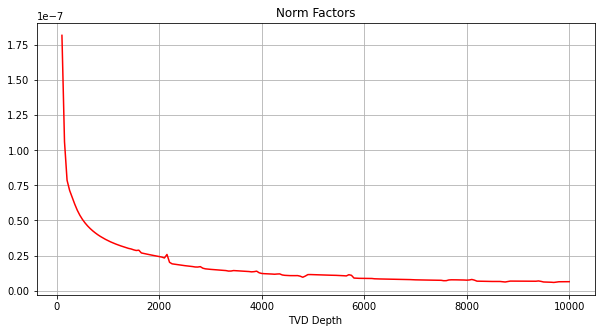

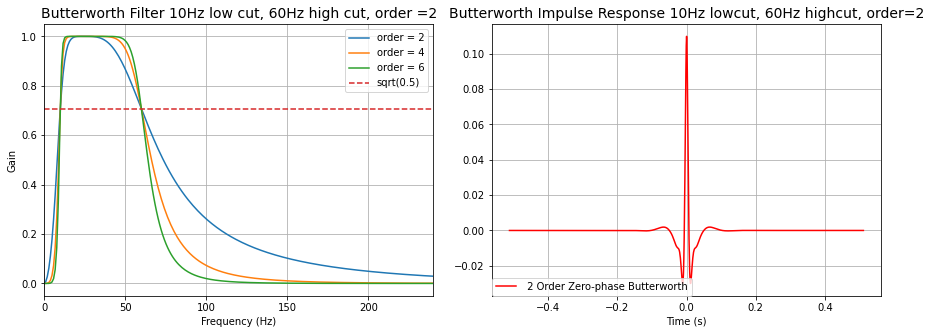

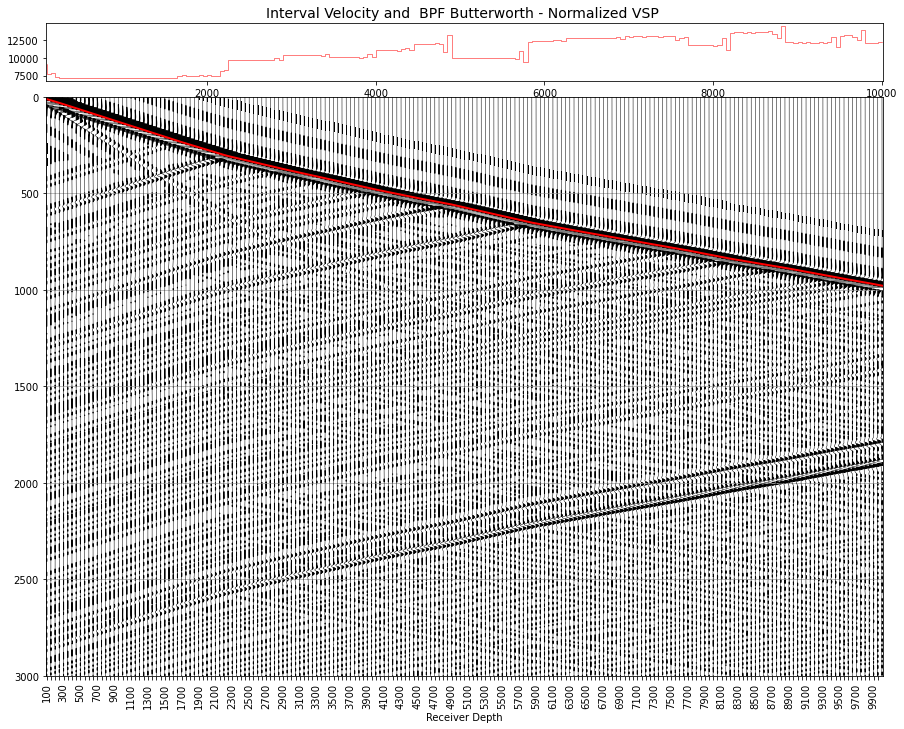


̲S̲i̲m̲p̲l̲e̲ ̲B̲P̲F̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:


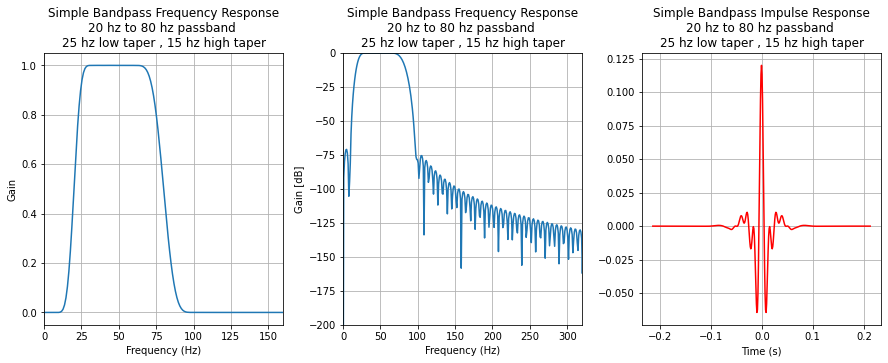

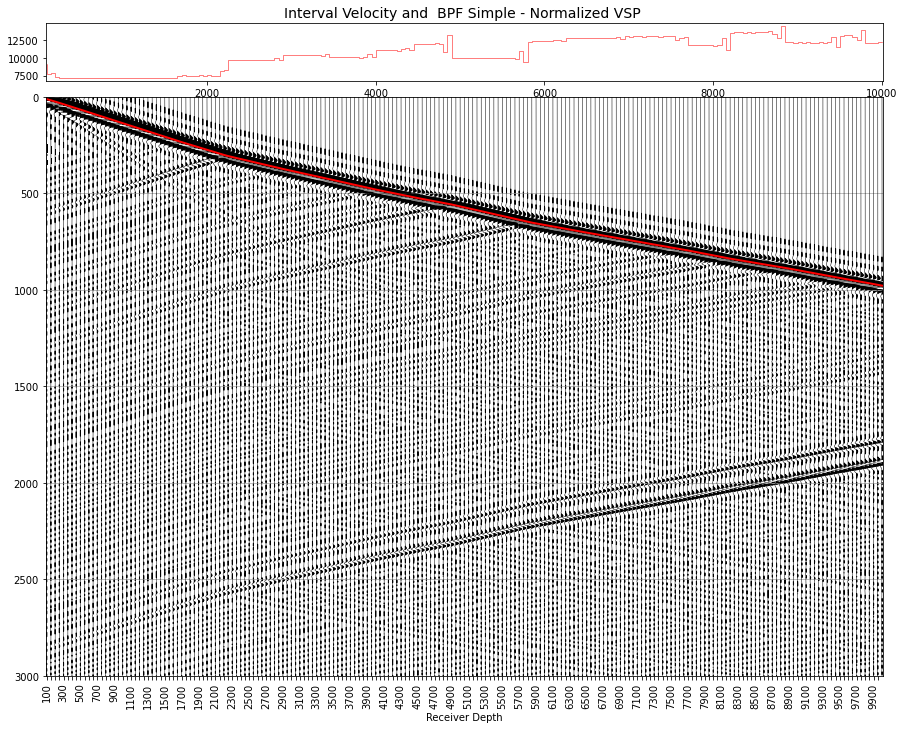

 presqueeze w shape : (512,)


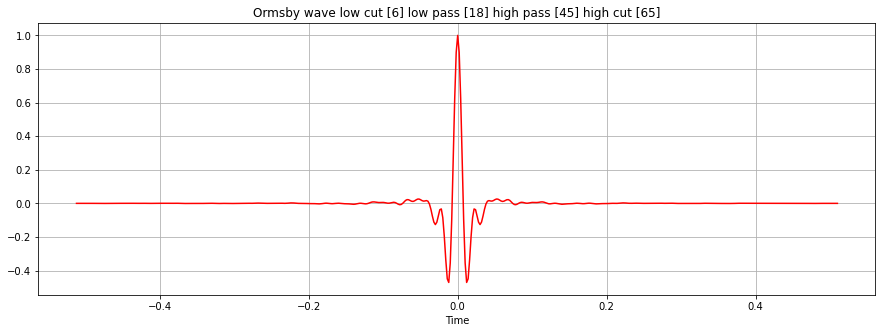

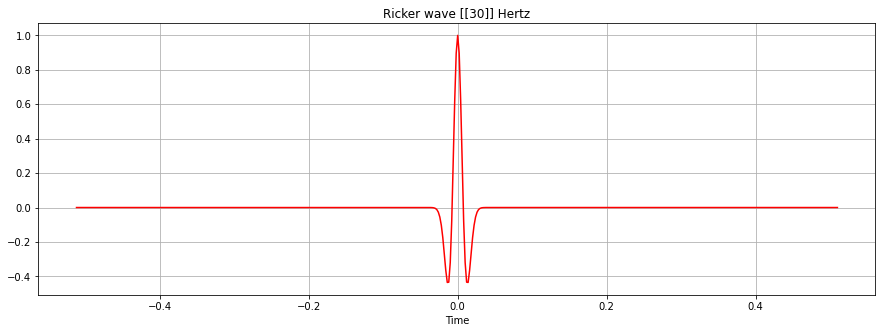


̲B̲u̲t̲t̲e̲r̲w̲o̲r̲t̲h̲ ̲W̲a̲v̲e̲l̲e̲t̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:

 fs : 1000.0  N : 1024  order : 3
 center : 513  a few values of x : 
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


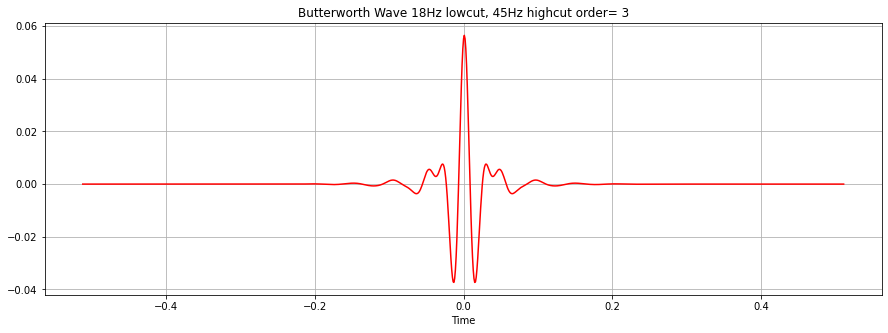


̲F̲r̲A̲n̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
fs : 1000.0


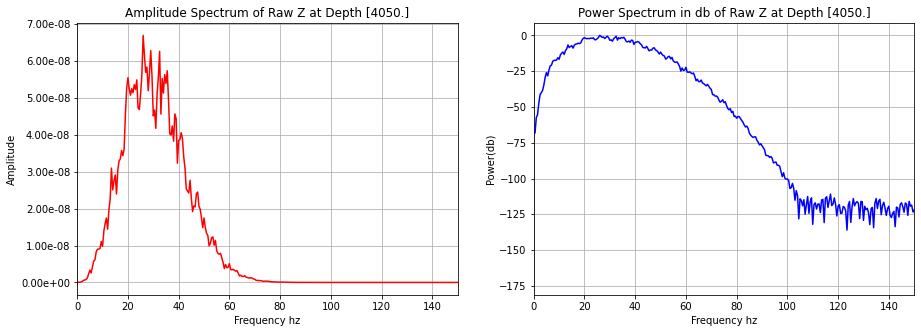

 buttfilt type : float32

̲F̲r̲A̲n̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
fs : 1000.0


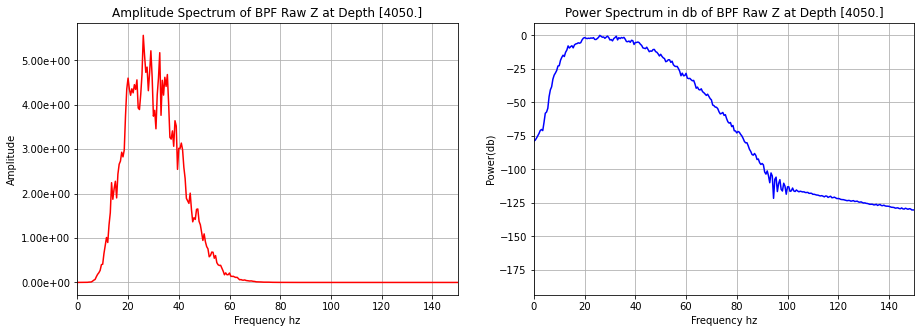


̲F̲r̲A̲n̲ ̲i̲m̲a̲g̲e̲2̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
 data shape : (198, 3050)  TTobs shape : (199,)
 trindex.min(): 1.0  trindex.max(): 199.0
fs : 1000.0
 final idata_win shape : (198, 3072)  idata shape : (198, 3050)  N : 3072
 keep : [ True  True  True ... False False False]  keep.size : 3072  freq shape : (1536,)


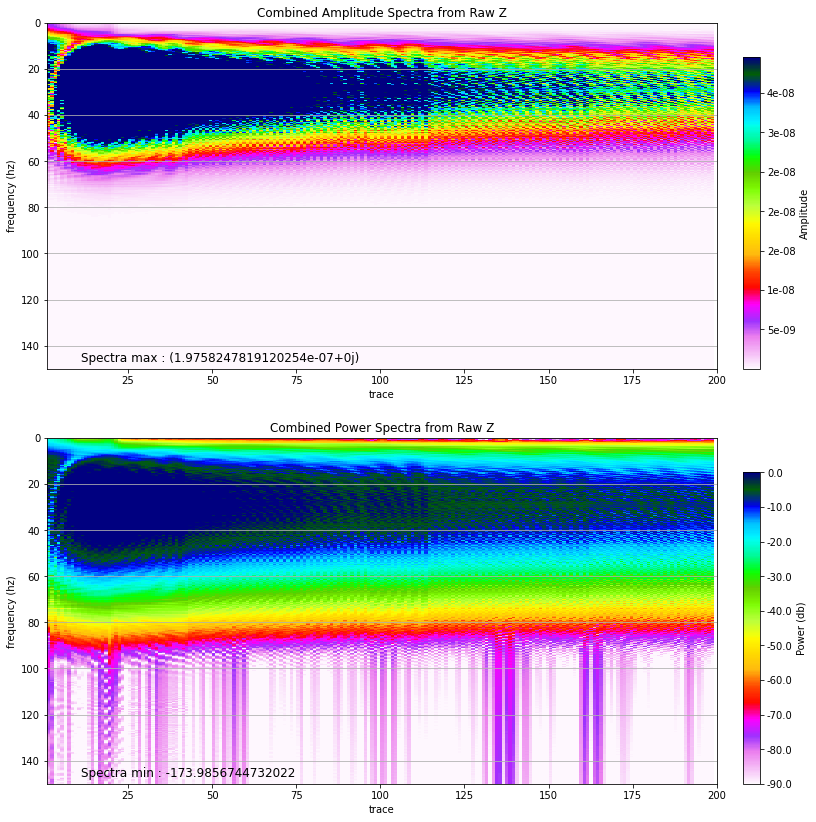


̲n̲e̲x̲t̲p̲o̲w̲2̲ ̲i̲n̲f̲o̲ ̲a̲n̲d̲ ̲p̲a̲r̲a̲m̲e̲t̲e̲r̲s
 x : 3050
 nextpow2 : 12.0

̲f̲k̲t̲r̲a̲n̲_̲n̲u̲m̲p̲y̲ ̲i̲n̲f̲o̲ ̲a̲n̲d̲ ̲p̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲b̲e̲f̲o̲r̲e̲ ̲f̲f̲t
 seis.T shape : (3050, 199) 
 numsamp : 3050 
 ntrace : 199
 rcvz shape : (199,) 
 t shape : (3050,) 
 dx : 50.0 
 dt : 0.001
 nf : 4096 
 nk : 4096
 fk shape : (4096, 4096)
 freq min -500.0  freq max 499.755859375
 k min -0.01  k max 0.0099951171875
 fk_for_plot shape : (4096, 2047)

̲f̲k̲ ̲p̲l̲o̲t̲ ̲i̲n̲f̲o̲ ̲a̲n̲d̲ ̲p̲a̲r̲a̲m̲e̲t̲e̲r̲s
fk shape : (2047, 4096)
 df : 0.244140625 
 stop freq index : 327 
 f shape : (4096,) 
 dk : 4.882812500000763e-06 
 startk : 511 
 stopk : 3582
 kvel, fvel: [0, -0.08329264322916667] [0, 499.755859375]  slope : -6000.0
 xy label location: (-0.00375, 22.5)


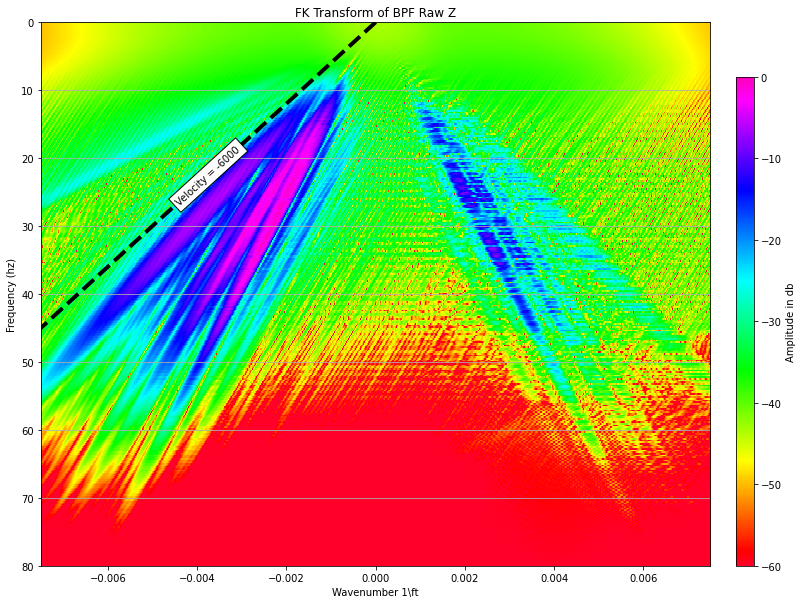


̲A̲t̲t̲r̲i̲b̲u̲t̲e̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
 fs : 1000.0 
  max trace amplitude :  5.060345e-08 
  max amplitude envelope :  5.3998524297812556e-08 
  max inst frequency :  499.9999316628345 
  max inst phase :  179.99818711949567
 inst freq shape : (199, 3049)
 inst amp shape : (199, 3050)
 freq_mid shape:  (3050,)  amp_mid shape:  (3050,)
VSPdata shape: (199, 3050) tindex shape : (199, 3050) rindex shape : (199, 3050)


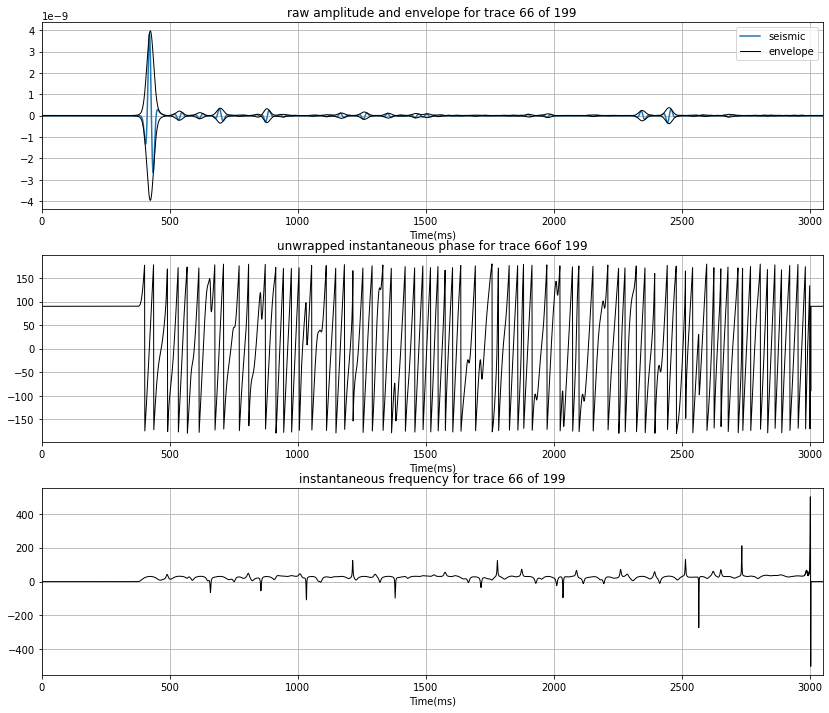

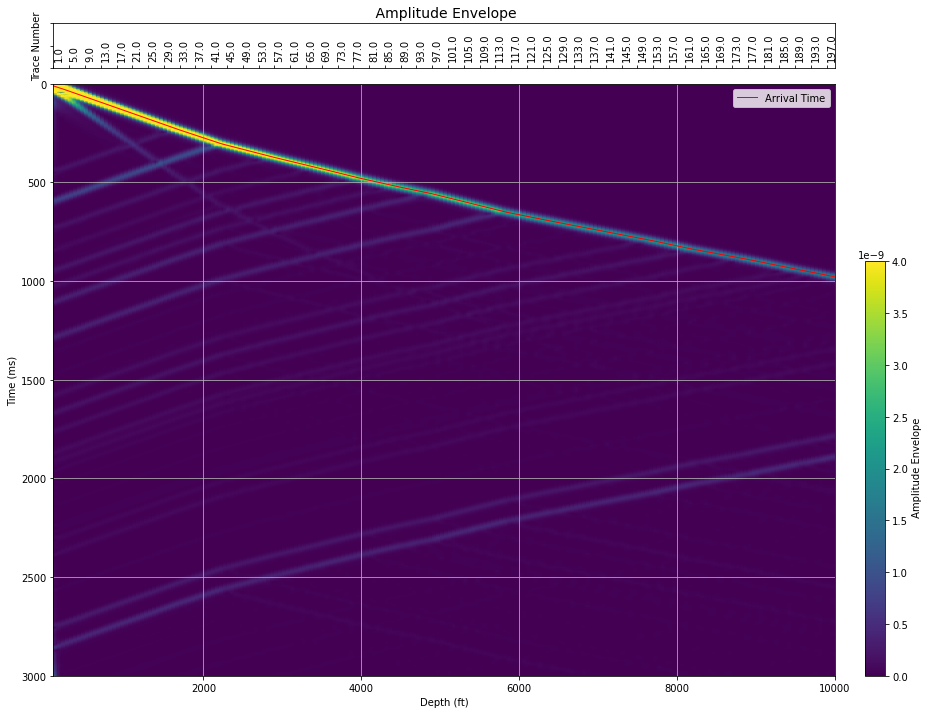

VSPdata shape: (199, 3050) tindex shape : (199, 3050) rindex shape : (199, 3050)


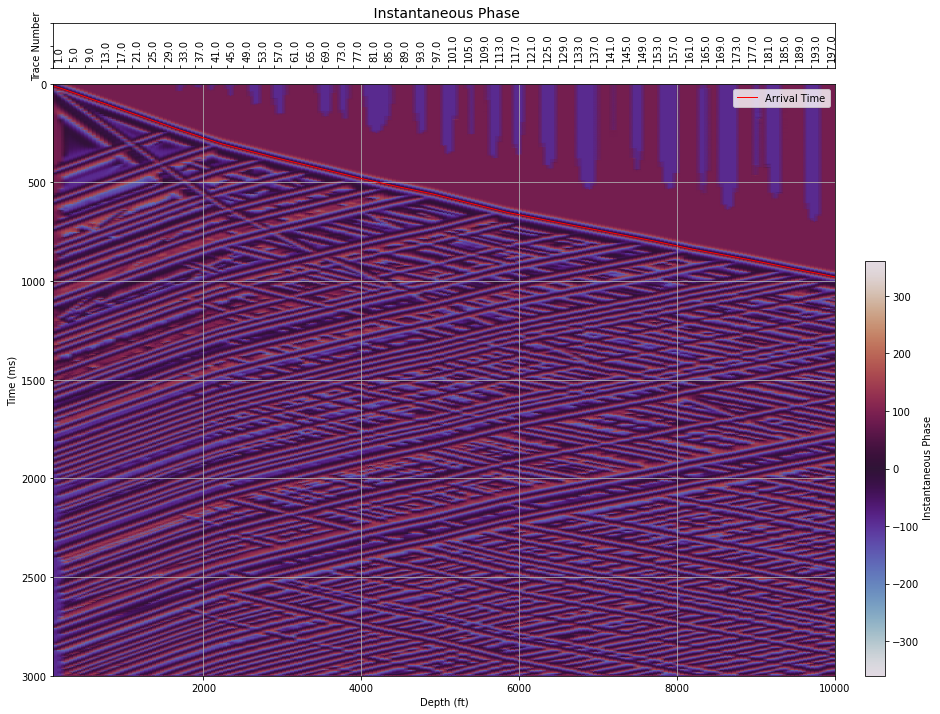

In [21]:
def main ():
    
    #################### get the ZVSP SEGY filename ############################
    
#    filename = ('C:\\Users\\acampbell45\\Documents\\Python_Scripts'
#        '\\Synthetic_data\\data\\zvsp_z_fd_mod6_12p5ft_grid_delayed.sgy')
#    filename = ('C:\\Users\\acampbell45\\Documents\\Python_Scripts'
#        '\\VSP-processing\\data\\Tillard_ZVSP_raw_z_stacked.sgy')

    filename = ('data\\zvsp_z_fd_mod6_12p5ft_grid_delayed.sgy')
    
    ################### input desired geometry parameters ######################
    
    RepVel= 5000     # replacement velocity
    SRD_ASL = 0    # SRD elevation above sea level
    DF_ASL = 0    # drill floor elevation ASL
    SrcElev = -10   # source elevation ASL

    ###################### run basic segy loading functions #################### 
    
    file_head = 'n'         # print binary and text header to screen    
    pr_thead = 'n'          # print a table of trace headers
   
    data, numsamp, samprate, fs, theader =  segyin.readsegyio3(filename, file_head, 
                                            DF_ASL, SrcElev, SRD_ASL, pr_thead)

    ############ geometry corrections and velocity calculations ################
    
    table = 'n'     # print a time-depth-velocity listing to screen y or n    
    vel_headers = geovel( theader, RepVel, table)
    
    ###################### trim arrays by receiver  ############################
    
    first_rcv =1
    last_rcv = 200   
    data_edit, theader_edit = depthlimit(data,vel_headers, first_rcv, last_rcv)
  
    ############  apply trace normalization if requested #######################  
    
    Data_norm = 'y'         # normalize data, n for gather norm, y for trace nrm
    DScalar = 1             # usually 1, may be removed in future    
    normed_edit = normalize(data_edit, Data_norm, theader_edit, DScalar)

    ################### Butterworth filter testing #############################
    
    # Sample rate and desired cutoff frequencies (in Hz).

    lowcut = 10
    highcut = 60
    qcplot = 'y'
    order  = 2     # order gets doubled by implementation of filter, be careful    
    numfsamp = 1024   # for wavelet QC plot, must be even      
    buttfilt = butter_bandpass_filter(normed_edit, lowcut, highcut, fs, order, 
                                      numfsamp, qcplot)
    # make a wiggle plot of traces
    plot_params = {"pol":'n', 
                    "Tmax":3000, "Tmin":0, 
                    "first_rcv":first_rcv, 
                    "spacing":'z', 
                    "skiplabel":4, 
                    "fs":fs, 
                    "norm":'n',
                    "scal":1000, 
                    "title_top":' BPF Butterworth - Normalized VSP ',
                  "info_wig":'n'}
    seisplots.wiggle_plot(theader_edit,buttfilt, **plot_params)
    
    ######################## Simple BPF testing ################################

    lowcut = 20
    highcut = 80
    rolloff_low = 15
    rolloff_high = 25
    
    simpfilt=simple_bpf(normed_edit, lowcut, highcut, rolloff_low,rolloff_high, fs)
    # make a wiggle plot of traces
    plot_params = {"pol":'n', 
                    "Tmax":3000, "Tmin":0, 
                    "first_rcv":first_rcv, 
                    "spacing":'z', 
                    "skiplabel":4, 
                    "fs":fs, 
                    "norm":'n',
                    "scal":1000, 
                    "title_top":' BPF Simple - Normalized VSP ',
                  "info_wig":'n'}
    seisplots.wiggle_plot(theader_edit,simpfilt, **plot_params)
    
    ######################## Ormsby Wavelet   ##################################
    timlength=1.024
    sampint = .002
    flimits = [6,18,45,65]
    ormwave = ormsby(timlength, sampint, flimits)
    
    ######################## Ricker Wavelet   ##################################
    timlength=1.024
    sampint = .002
    flimits = 30
    rickwave = ricker(timlength, sampint, flimits)
    
    ###################### Butterworth Wavelet   ###############################
    lowcut = 18
    highcut = 45
    order  = 3   # order gets doubled by implementation of filter, be careful    
    numfsamp = 1024   # for wavelet QC plot, must be even     
    butterworth(lowcut, highcut, fs, numfsamp, order)
    
    ########################  FRequency ANalysis    ############################
    
    trace = 80
    time_win = 'y' # window trace prior to fft
    time_range = [0, 2000]
    freq_range = [0, 150]    
    title_fran = 'Raw Z'    
    FrAn(data_edit, time_range, freq_range, theader_edit, trace, fs, 
         time_win, title_fran)
    
    title_fran = 'BPF Raw Z'
    print( ' buttfilt type :',buttfilt.dtype)    
    FrAn(buttfilt, time_range, freq_range, theader_edit, trace, fs, 
         time_win, title_fran)

    # 2D spectra - a spectrum per trace
    spacing = 'z' # Z for traces spread by receiver depth    
    scale = 5 # scale up image apmlitude plot
    title_fran = 'Raw Z'
    time_win = 'y' # window trace prior to fft
    time_range = [0, 3050]
    freq_range = [0, 150]    
    trace_range = [1, 200]
    db_range = [-90,0]
    FrAn_2d(data_edit, time_range, theader_edit, fs, spacing, 
         db_range, freq_range, trace_range, scale, title_fran, time_win)
    
    ############################ FK analysis ####################################
    
    ishift = 1                                      # display positive freqs.
    title_fk='FK Transform of BPF Raw Z'
    line_velocity=-6000    
    fktrans, freqnp_unwrap, knp_unwrap, numsamp, ntrace \
    = fktran_numpy(buttfilt, theader_edit, fs, ishift, title_fk, line_velocity)
                
    ################# calculate instantaneous attributes ###################
    
    data_env, data_ifreq, data_iphase = attributes(data_edit,fs)
     
    colorplot_params = {"pol":'n', 
                    "Tmax":3000, "Tmin":0, 
                    "first_rcv":first_rcv, 
                    "spacing":'z', 
                    "skiplabel":4,
                    "samp_decimate":1,
                    "fs":fs, 
                    "norm":'n',
                    "min_amp":0, "max_amp":.4e-8,
                    "title_top":' Amplitude Envelope',
                    "color": 'viridis',
                    "png":'n'}
    seisplots.plotcolor(theader_edit, data_env, **colorplot_params)
    
    colorplot_params = {"pol":'n', 
                    "Tmax":3000, "Tmin":0, 
                    "first_rcv":first_rcv, 
                    "spacing":'z', 
                    "skiplabel":4,
                    "samp_decimate":1,
                    "fs":fs, 
                    "norm":'n',
                    "min_amp":-360, "max_amp":360,
                    "title_top":' Instantaneous Phase',
                    "color": 'twilight',
                    "png":'n'}
    seisplots.plotcolor(theader_edit, data_iphase, **colorplot_params)        
main()